# **Initialization**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_file = "/Volumes/PortableSSD/airbus-ship-detection/train_ship_segmentations_v2.csv"
root_dir = "/Volumes/PortableSSD/airbus-ship-detection/train_v2/"
data = pd.read_csv(csv_file)

print(data.head())

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB
None


In [5]:
print(f"Unique images: {data['ImageId'].nunique()}")

Unique images: 192556


In [6]:
# Check the distribution of missing data
print(data.isnull().sum())

ImageId               0
EncodedPixels    150000
dtype: int64


has_ship
False    150000
True      42556
Name: count, dtype: int64


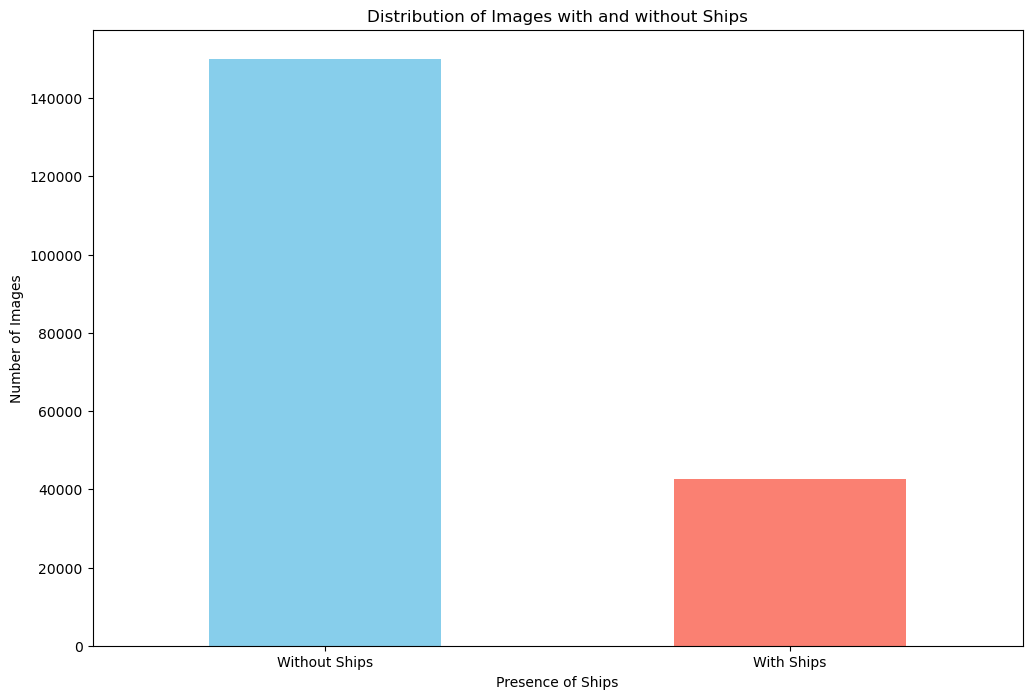

In [7]:
# Add a column to mark the presence of ships
data['has_ship'] = data['EncodedPixels'].notnull()

# Group by ImageId and check the presence of ships
grouped_data = data.groupby('ImageId')['has_ship'].any().reset_index()

# Count of images with and without ships
ship_count = grouped_data['has_ship'].value_counts()
print(ship_count)

plt.figure(figsize=(12, 8))
ship_count.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Images with and without Ships')
plt.xlabel('Presence of Ships')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1], labels=['Without Ships', 'With Ships'], rotation=0)
plt.show()

In [8]:
# Group by ImageId and count the number of ships on each image
ship_counts_per_image = data.groupby('ImageId')['EncodedPixels'].count().reset_index()
ship_counts_per_image.columns = ['ImageId', 'ship_count']

# Distribution of the number of ships on images
ship_distribution = ship_counts_per_image['ship_count'].value_counts()
print(ship_distribution)

ship_count
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64


# **Distribution of the Number of Ships on Images**


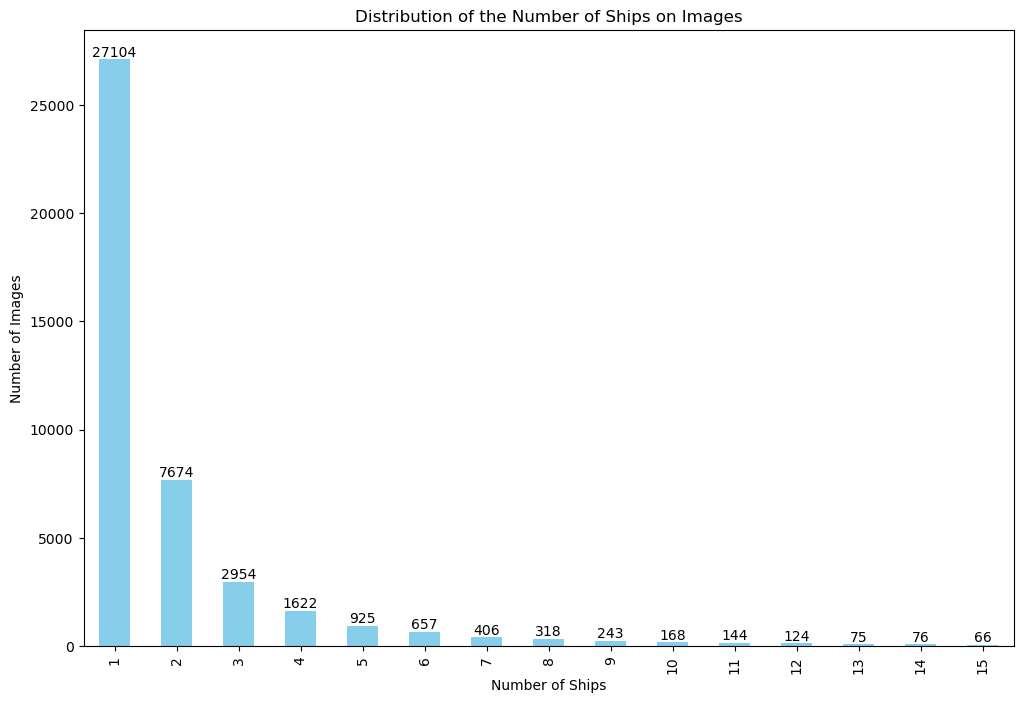

In [9]:
# Filter images with at least one ship
ship_counts_per_image = ship_counts_per_image[ship_counts_per_image['ship_count'] > 0]

# Distribution of the number of ships on images
ship_distribution = ship_counts_per_image['ship_count'].value_counts().sort_index()

plt.figure(figsize=(12, 8))
ax = ship_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of the Number of Ships on Images')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')

for i in ax.containers:
    ax.bar_label(i)

plt.show()

# **Example of an Input Image and сorresponding Mask**


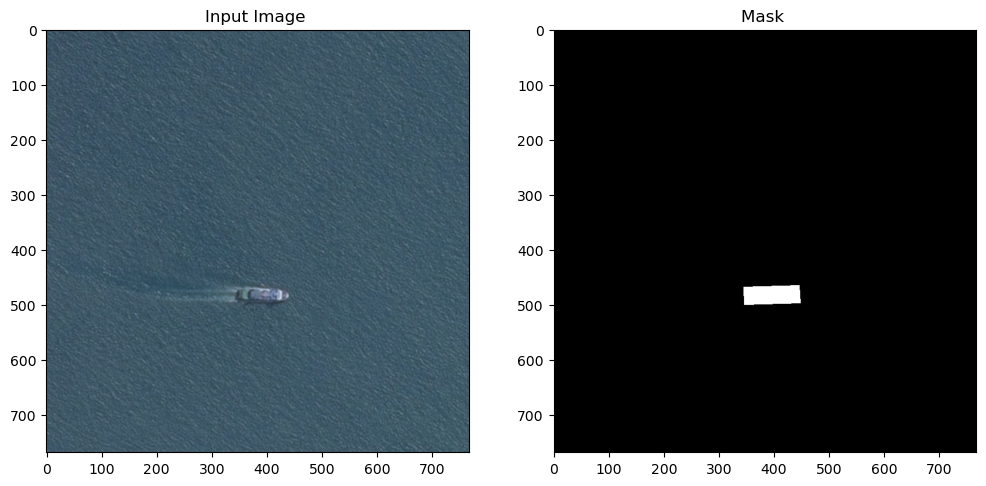

In [10]:
from skimage.io import imread
import os

# Filter images with ships
data_with_ships = data[data['EncodedPixels'].notnull()]

# Decoding masks in Run-Length Encoding format
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

# Visualize the image and mask
def visualize_image_and_mask(image_id, root_dir, title_suffix=''):
    image_path = os.path.join(root_dir, image_id)
    image = imread(image_path)
    
    masks = data_with_ships[data_with_ships['ImageId'] == image_id]['EncodedPixels'].tolist()
    mask = np.zeros((768, 768), dtype=np.uint8)
    
    for mask_rle in masks:
        mask += rle_decode(mask_rle)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(image)
    ax[0].set_title(f'Input Image {title_suffix}')
    
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f'Mask {title_suffix}')
    
    plt.show()

# Visualization for one example
example_image_id = data_with_ships['ImageId'].values[0]
visualize_image_and_mask(example_image_id, root_dir)


# **Percentage of the Image Area Occupied by Ships**


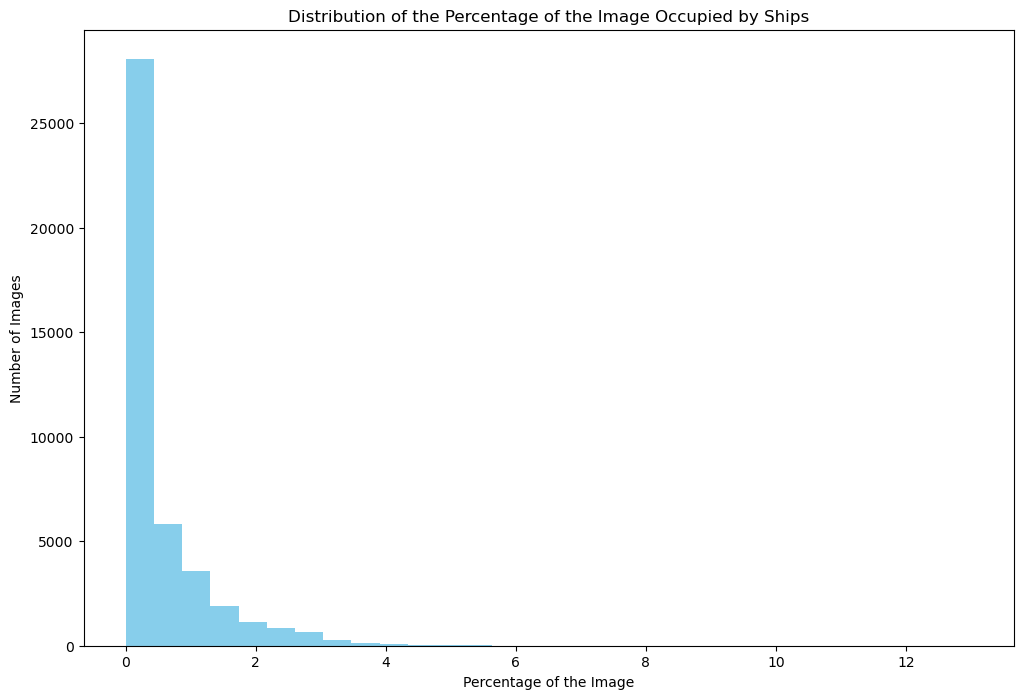

In [11]:
# Filter images with ships
data_with_ships = data[data['EncodedPixels'].notnull()]

# Calculate the percentage of the image occupied by ships
def calculate_ship_percentage(rle_list, image_shape=(768, 768)):
    total_pixels = image_shape[0] * image_shape[1]
    ship_pixels = sum(np.sum(rle_decode(rle)) for rle in rle_list)
    return (ship_pixels / total_pixels) * 100

# Group masks by ImageId
grouped_data = data_with_ships.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

# Add a column with the percentage of the image occupied by ships
grouped_data['ship_percentage'] = grouped_data['EncodedPixels'].apply(calculate_ship_percentage)

plt.figure(figsize=(12, 8))
plt.hist(grouped_data['ship_percentage'], bins=30, color='skyblue')
plt.title('Distribution of the Percentage of the Image Occupied by Ships')
plt.xlabel('Percentage of the Image')
plt.ylabel('Number of Images')
plt.show()

# **Heatmap of Ship Positions**


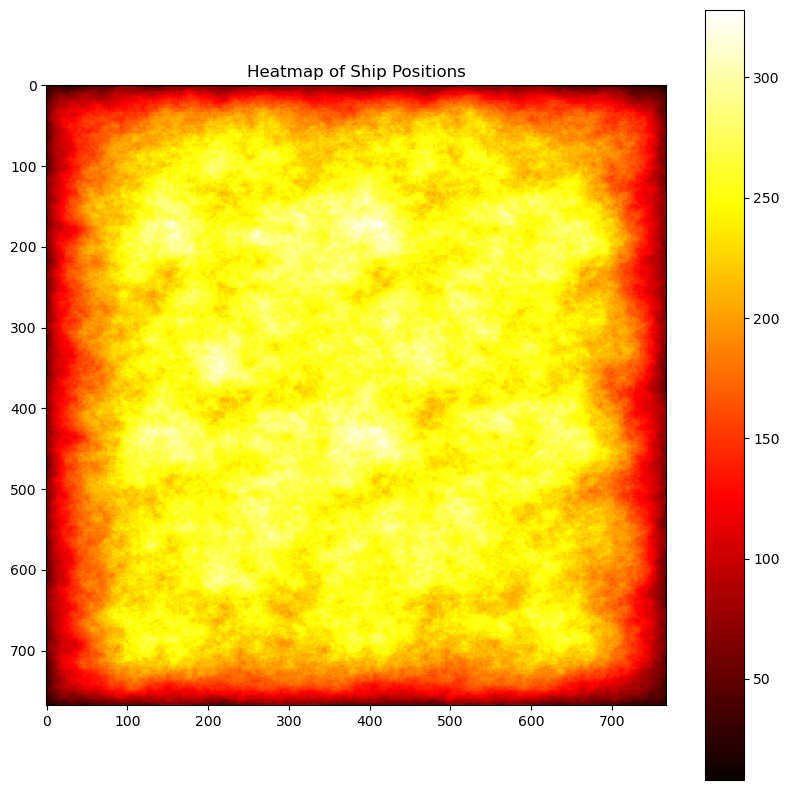

In [12]:
heatmap = np.zeros((768, 768))

for mask_rle in data_with_ships['EncodedPixels']:
    heatmap += rle_decode(mask_rle)

plt.figure(figsize=(10, 10))
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title('Heatmap of Ship Positions')
plt.colorbar()
plt.show()

# **Average, Minimum, and Maximum Ship Area**


In [13]:
# Adding 'ship_area' column to calculate the ship area
def calculate_ship_area(mask_rle):
    mask = rle_decode(mask_rle)
    return np.sum(mask)

data_with_ships['ship_area'] = data_with_ships['EncodedPixels'].apply(calculate_ship_area)

# Calculating the average, minimum, and maximum ship areas
average_ship_area = data_with_ships['ship_area'].mean()
min_ship_area = data_with_ships['ship_area'].min()
max_ship_area = data_with_ships['ship_area'].max()

print(f'Average ship area: {average_ship_area:.2f} pixels')
print(f'Minimum ship area: {min_ship_area} pixels')
print(f'Maximum ship area: {max_ship_area} pixels')

Average ship area: 1567.40 pixels
Minimum ship area: 2 pixels
Maximum ship area: 25904 pixels


/var/folders/kk/gkc7tsxj1ml1y68bbcxbj6440000gn/T/ipykernel_54687/3042116630.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_ships['ship_area'] = data_with_ships['EncodedPixels'].apply(calculate_ship_area)


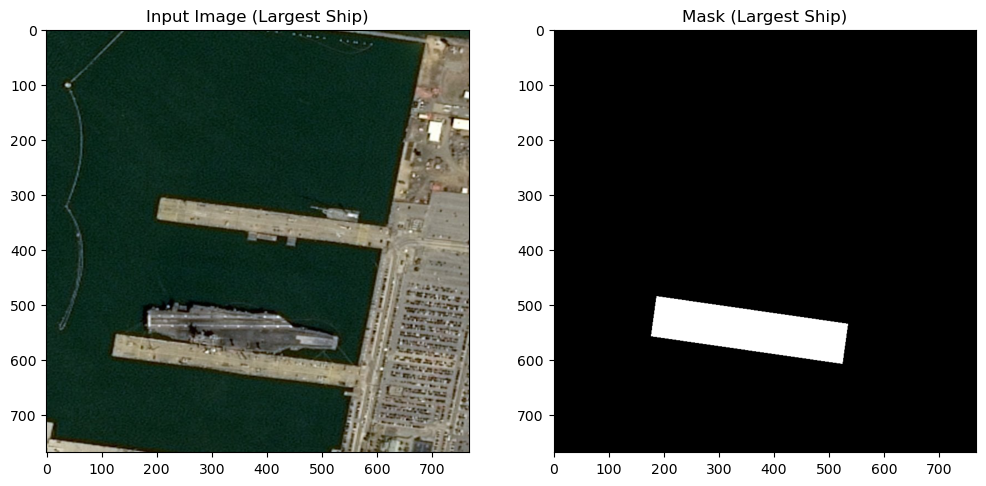

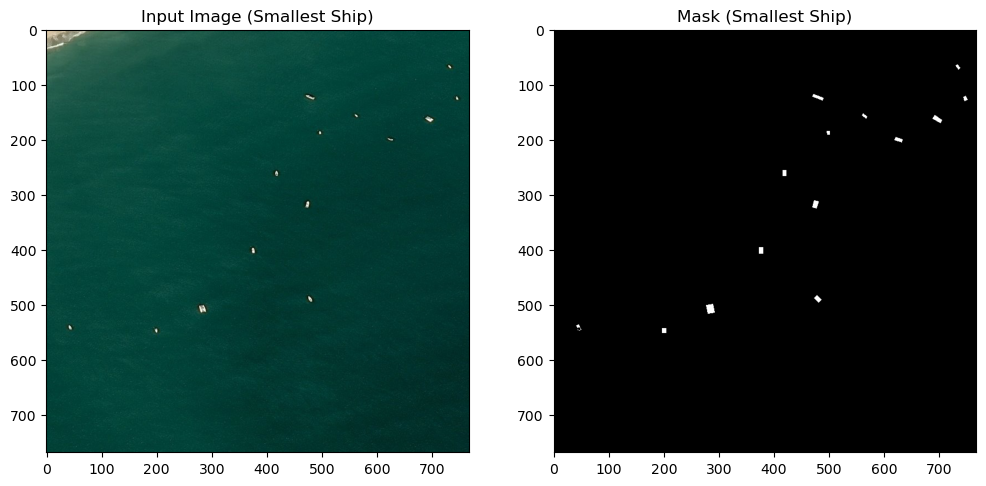

In [14]:
# Visualization for the largest ship
max_ship = data_with_ships[data_with_ships['ship_area'] == max_ship_area].iloc[0]
visualize_image_and_mask(max_ship['ImageId'], root_dir, title_suffix='(Largest Ship)')

# Visualization for the smallest ship
min_ship = data_with_ships[data_with_ships['ship_area'] == min_ship_area].iloc[0]
visualize_image_and_mask(min_ship['ImageId'], root_dir, title_suffix='(Smallest Ship)')

# **Visualizations for Clarity**


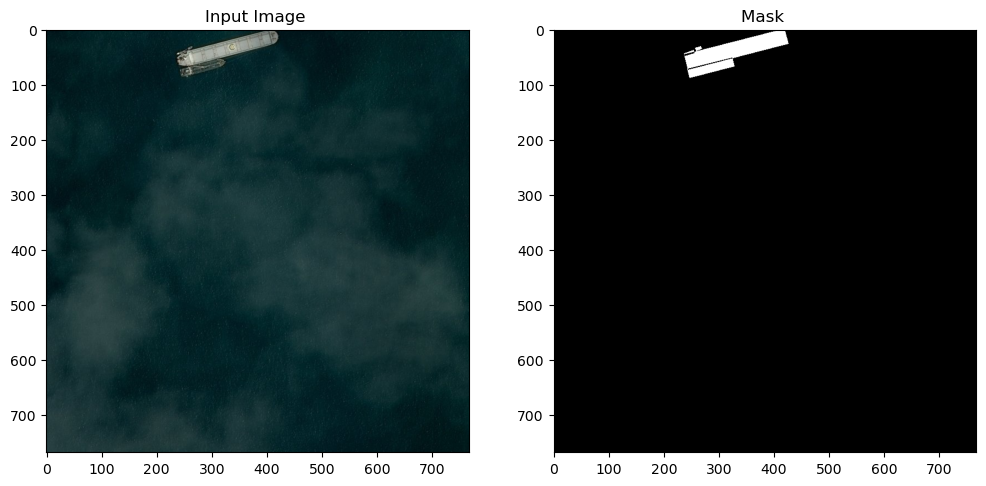

In [15]:
from scipy.spatial import distance

# Calculate pixel coordinates of the mask
def get_pixel_coordinates(mask_rle):
    mask = rle_decode(mask_rle)
    return np.argwhere(mask == 1)

# Check if ships are close to each other
def are_ships_close(coords_list, min_distance=50):
    """
    Determine if any ships in the list of coordinates are close to each other.
    """
    for i, coords1 in enumerate(coords_list):
        for j, coords2 in enumerate(coords_list):
            if i >= j:
                continue
            if distance.cdist(coords1, coords2).min() < min_distance:
                return True
    return False

# Find images with more than two ships
def find_images_with_more_than_two_ships(data_with_ships):
    images_with_more_than_two_ships = []
    for image_id in data_with_ships['ImageId'].unique():
        masks = data_with_ships[data_with_ships['ImageId'] == image_id]['EncodedPixels'].tolist()
        if len(masks) > 2:
            coords_list = []
            for mask_rle in masks:
                coords = get_pixel_coordinates(mask_rle)
                coords_list.append(coords)
            
            if are_ships_close(coords_list):
                images_with_more_than_two_ships.append(image_id)
    
    return images_with_more_than_two_ships

# Find images with more than two ships
images_with_more_than_two_ships = find_images_with_more_than_two_ships(data_with_ships)

# Visualize one such image (e.g., the fifth in the list)
if images_with_more_than_two_ships:
    example_image_id = images_with_more_than_two_ships[4]
    visualize_image_and_mask(example_image_id, root_dir)
else:
    print("No images with more than two ships found.")

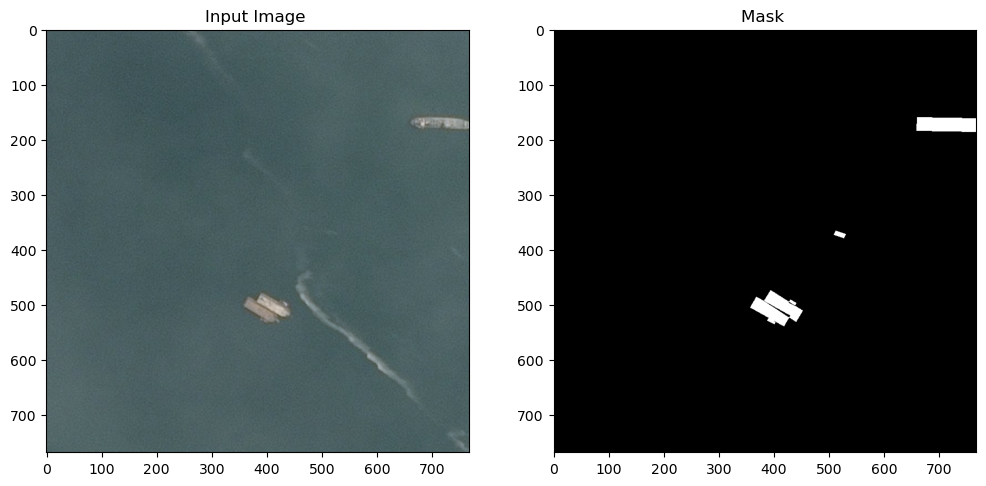

In [20]:
if images_with_more_than_two_ships:
    example_image_id = images_with_more_than_two_ships[24]
    visualize_image_and_mask(example_image_id, root_dir)

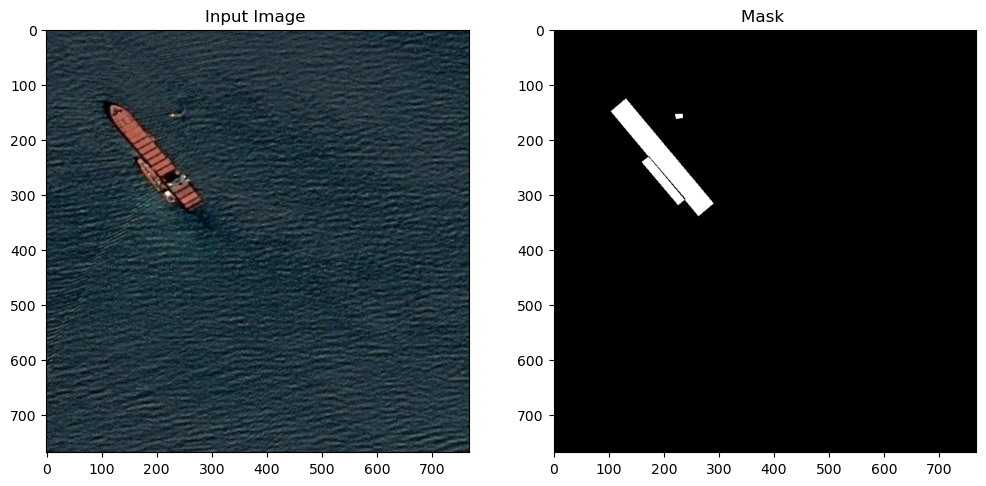

In [21]:
if images_with_more_than_two_ships:
    example_image_id = images_with_more_than_two_ships[55]
    visualize_image_and_mask(example_image_id, root_dir)

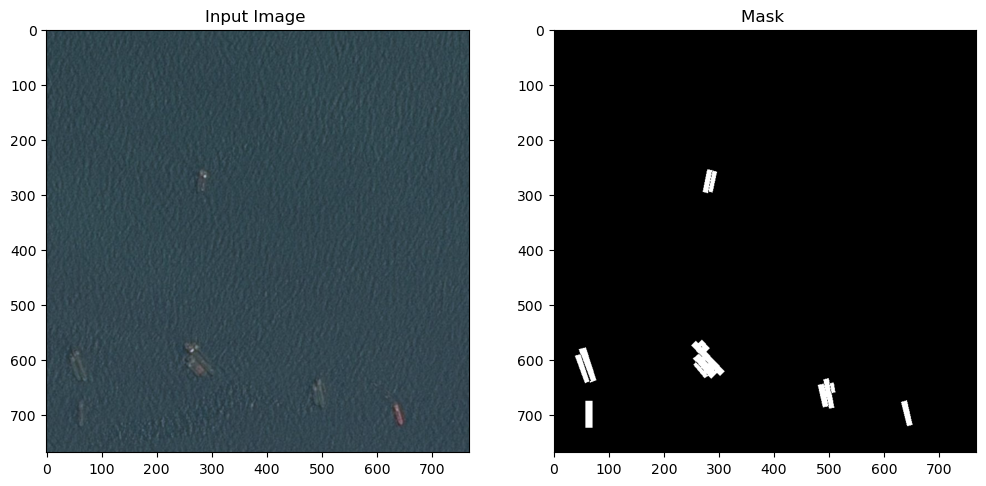

In [22]:
if images_with_more_than_two_ships:
    example_image_id = images_with_more_than_two_ships[58]
    visualize_image_and_mask(example_image_id, root_dir)

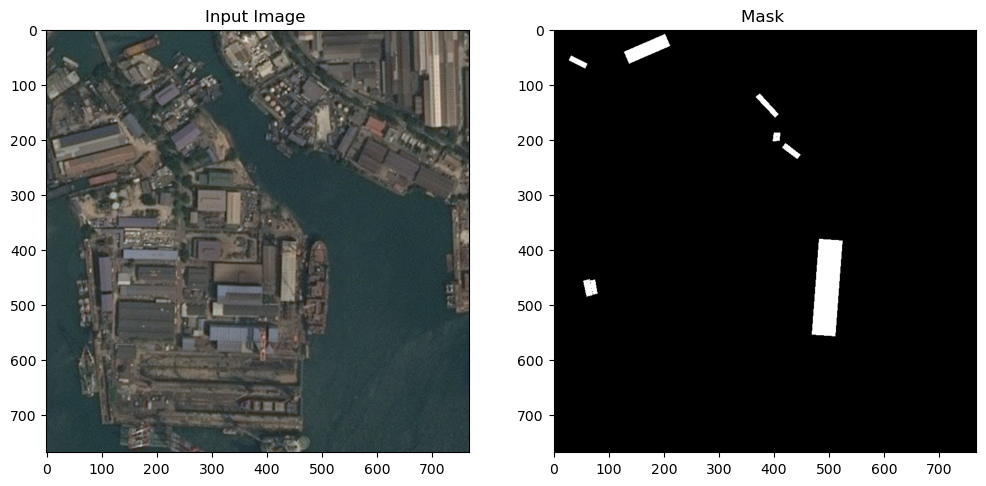

In [19]:
if images_with_more_than_two_ships:
    example_image_id = images_with_more_than_two_ships[27]
    visualize_image_and_mask(example_image_id, root_dir)

# **Conclusion**


There are 192,556 unique images, with 150,000 images without ships and 42,556 images with ships. Due to the significant imbalance, **it will be necessary to balance the data**. There is also a notable imbalance in the number of ships per image:   

1 ship: 27,104 images - 63.69%  
2 ships: 7,674 images - 18.03%  
3 ships: 2,954 images - 6.94%  
4 ships: 1,622 images - 3.81%  
5 ships: 925 images - 2.17%  
6 ships: 657 images - 1.54%  
7 ships: 406 images - 0.95%  
8 ships: 318 images - 0.75%  
9 ships: 243 images - 0.57%  
10 ships: 168 images - 0.39%  
11 ships: 144 images - 0.34%  
12 ships: 124 images - 0.29%  
13 ships: 75 images - 0.18%  
14 ships: 76 images - 0.18%  
15 ships: 66 images - 0.16%  

By constructing a heatmap of ship positions, it is noticeable that ships rarely occupy positions at the edges of the image and are much more often located in the center. **It might be worthwhile to apply data augmentation to address this.**

Additionally, by calculating the area occupied by ships in the images, it is observed that **ships occupy on average between 0.1% to 2% of the image, and in rare cases, between 2% to 4%.**

The smallest ship is depicted on just 2 pixels, while the largest one occupies 25,904 pixels. **On average, a ship occupies 1,567 pixels.**

Moreover, when examining the image and mask of the largest ship, it can be seen that **the ship's shape and the mask do not perfectly match**. It was also found that the masks do not have rounded shapes, as ships usually do, which could negatively affect the results. **It is worth considering the use of Pseudo-Labeling.**

As illustrated in the images, **ships are also often positioned close to each other**, making it difficult for a simple model to distinguish between them, and it may be necessary to apply techniques to address this feature.

As seen in the last image, ships can be found in bays very close to similarly shaped buildings.